# Active Session 1: Introduction to CNN

#Important Note

Lecture notes and notebooks must not be copied and/or distributed without the express permission of ITS.





#1. Problem Definition: Probing into the Data

In this dataset, we will explore a medical case study: (malignant) melanoma, which is a type of skin cancer that develops from the pigment-producing cells known as melanocytes. 

Identifying melanoma at an early stage is very crucial; as  the early detection can vastly increase your chances for cure up to 99%. The survival rate drops from to 66% if the disease reaches the lymph nodes and
27% if it spreads to distant organs [[1]](https://www.skincancer.org/skin-cancer-information/melanoma/melanoma-warning-signs-and-images/). 

The problem has serious consequences hence has been addressed by the community in different ways, mainly revolving around alternative CNN architectures and pre-trained and/or attention based models. We will use a relatively smaller database as an exercise to explore the CNN implementation in TF and how to call pre-trained models for the task later on. 




# 2. Preparing the enviroment

Import the Python libraries that we will need to (i) load the data, (ii) analyze it, (iii) create our model, (iv) process the results.

In [6]:
!pip install ipython-autotime
%load_ext autotime

time: 256 µs (started: 2022-05-03 17:24:28 +00:00)


In [7]:
#Importing the necessary libraries
import math
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
import matplotlib as mpl
from glob import glob
from PIL import Image
import cv2

time: 2.25 s (started: 2022-05-03 17:24:28 +00:00)


In [8]:
# Data Preparation and Scoring
from sklearn import preprocessing as pp
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from matplotlib.colors import LogNorm
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score
import itertools
from tqdm import tqdm
from tensorflow.keras.utils import plot_model
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score,plot_confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, cohen_kappa_score
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from keras.preprocessing.image import ImageDataGenerator


time: 8.34 s (started: 2022-05-03 17:24:30 +00:00)


In [9]:
# ML Algorithms to be used
import tensorflow as tf
from tensorflow import keras
from keras import optimizers, models, layers, regularizers
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Activation, Dense, Dropout, Conv2D, MaxPooling2D
from keras.layers import BatchNormalization, Input, Lambda, Flatten

from keras.utils.np_utils import to_categorical

tf.__version__


'2.8.0'

time: 30.8 ms (started: 2022-05-03 17:24:39 +00:00)


In [10]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0
time: 3.84 s (started: 2022-05-03 17:24:39 +00:00)


# 3. Pre-processing


## Loading the Data

We need to upload the dataset to Colab enviroment. The original  dataset is coming from the ISIC (International Skin Image Collaboration) Archive. It includes 1800 pictures of benign moles and 1497 pictures of malignant classified moles. The database have all been resized to low resolution (224x224x3) RGB. 

The data can be either loaded manually or can be read from google drive. We will follow the second route.

In [11]:
# Loading the data

#Local drive:
#from google.colab import files
#uploaded = files.upload()


time: 1.48 ms (started: 2022-05-03 17:24:43 +00:00)


In [12]:
# Loading the data
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

time: 7.13 s (started: 2022-05-03 17:24:43 +00:00)


In [13]:
# Note that you need to insert your own id for your file in the cloud.
CNN_data = drive.CreateFile({'id':'1fzaWN9j6FGIvkdaj6qJIKHZJRS9gP-ty'}) 
CNN_data.GetContentFile('CNN.zip')


time: 5.11 s (started: 2022-05-03 17:24:50 +00:00)


In [14]:
# The file is downloaded on the cloud workspace:
!ls

CNN.zip  data  my_best_model_2.h5  my_best_model.h5  sample_data  test	train
time: 187 ms (started: 2022-05-03 17:24:55 +00:00)


In [15]:
#Unzipping the flie:
!unzip -qq CNN.zip
!ls

replace data/test/benign/1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
CNN.zip  data  my_best_model_2.h5  my_best_model.h5  sample_data  test	train
time: 1min 22s (started: 2022-05-03 17:24:55 +00:00)


## Train-Test Split

OUr task is binary classification, which is supervised learning. Therefore, we need to create a train/test split. In the original dataset, this was already done to present the same split to those who would dive into the challange -- just be fair. So our task here is to take these folders, create objects and assign labels based on the folder they belong to. 

Note that we do not have any other features. A more recent, higher resolution database also provides additional information on the samples. You can eplore the newer challange from here:

https://www.kaggle.com/c/siim-isic-melanoma-classification

We will look into a bit older but smaller dataset, particularly to discuss the role of transfer learning in the following lecture. 

Now returning back to our problem, lets create our training-test data:

In [16]:
# Creating a function to read the images from the files:
def image_reader(directory,size=224):
    images = []
    # We are going to use Python Imaging Library for image management.
    #for more, you can check:
    #https://pillow.readthedocs.io/en/stable/reference/Image.html#
    #https://pillow.readthedocs.io/en/stable/reference/Image.html?highlight=convert#PIL.Image.Image.convert
    readed = lambda image_name: np.asarray(Image.open(image_name).convert("RGB"))
    # We will create a loop for reading images in a given directory and resize it if needed.
    #---------------------------------------------------------------------------
    # Just to have a cool window in the progress, we will use tqdm.
    # "tqdm derives from the Arabic word taqaddum (تقدّم) which can mean “progress,” 
    # and is an abbreviation for “I love you so much” in Spanish (te quiero demasiado). 
    # Instantly make your loops show a smart progress meter - just wrap any iterable with 
    # tqdm(iterable), and you're done!".
    #---------------------------------------------------------------------------
    for i_image in tqdm(os.listdir(directory)):
        PATH = os.path.join(directory,i_image)
        img_loop = readed(PATH)
        # Resizing image if needed:
        img_loop = cv2.resize(img_loop, (size,size))
        # Normalizing the colors
        #-----------------------------------------------------------------------
        # RGB (Red, Green, Blue) are 8 bit each and the range for each individual 
        # colour is 0-255 (2^8 = 256). By dividing by 255, the 0-255 range is converted to
        # a range between 0.0-1.0.
        #-----------------------------------------------------------------------
        images.append(np.array(img_loop)/255.)
    return images

time: 16.9 ms (started: 2022-05-03 17:26:17 +00:00)


In [17]:
#lets remember the files:
!ls

CNN.zip  data  my_best_model_2.h5  my_best_model.h5  sample_data  test	train
time: 160 ms (started: 2022-05-03 17:26:17 +00:00)


In [18]:
# Reading the images
#train data:
benign_train = np.array(image_reader('./data/train/benign'))
malignant_train = np.array(image_reader('./data/train/malignant'))
#test data:
benign_test = np.array(image_reader('./data/test/benign'))
malignant_test = np.array(image_reader('./data/test/malignant'))

100%|██████████| 300/300 [00:00<00:00, 448.10it/s]


time: 15.3 s (started: 2022-05-03 17:26:17 +00:00)


Note that the ratio of benign/malignant is relatively balanced. This is an important information as it affects our evaluation matrices (you may check the classification lecture of DDE1 for further information). 

Now we have read the images and converted them into numpy arrays. The next step is to create labels. This could have been done with the `image_reader` as well. 

In [19]:
print(np.shape(benign_train), np.shape(benign_test))
print(np.shape(malignant_train), np.shape(malignant_test))

(1440, 224, 224, 3) (360, 224, 224, 3)
(1197, 224, 224, 3) (300, 224, 224, 3)
time: 1.92 ms (started: 2022-05-03 17:26:33 +00:00)


In [20]:
# Creating individual labels:
#----------------------------
y_benign_train = np.zeros(benign_train.shape[0])
y_malignant_train = np.ones(malignant_train.shape[0])
y_benign_test = np.zeros(benign_test.shape[0])
y_malignant_test = np.ones(malignant_test.shape[0])
#
# Merging the arrays: 
#----------------------------
#images:
X_train = np.concatenate((benign_train, malignant_train), axis = 0)
#labels:
y_train = np.concatenate((y_benign_train, y_malignant_train), axis = 0)
#images:
X_test = np.concatenate((benign_test, malignant_test), axis = 0)
#labels:
y_test = np.concatenate((y_benign_test, y_malignant_test), axis = 0)

time: 2.85 s (started: 2022-05-03 17:26:33 +00:00)


In [21]:
del benign_train, malignant_train, benign_test, malignant_test
del y_benign_train, y_malignant_train, y_benign_test, y_malignant_test

time: 1.11 ms (started: 2022-05-03 17:26:36 +00:00)


In [22]:
# Since the data is perfectly ordered in label, we need to suffle it:
#
# first we will create a list of random numbers with the same size of our arrays.
# then reorder them accordingly.
s = np.arange(X_train.shape[0])
np.random.shuffle(s) 
X_train = X_train[s]
y_train = y_train[s]
# The same is done for the test data:
s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
y_test = y_test[s]

time: 2.99 s (started: 2022-05-03 17:26:36 +00:00)


## Visualization of the samples
We do not have many options for EDA. Lets see how the image samples look like. 

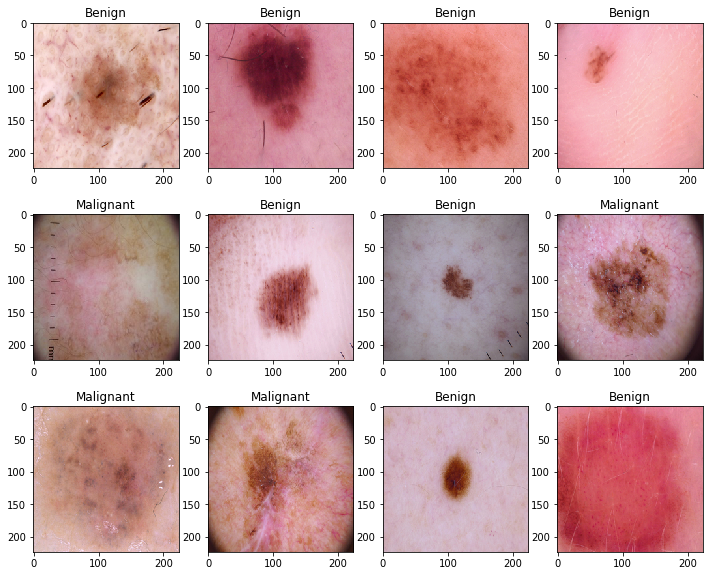

In [23]:
#Creating a figure including sub-figures:
fig=plt.figure(figsize=(12, 10))
for i in range(1, 12 +1):
    ax = fig.add_subplot(3, 4, i)
    if y_train[i] == 0:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Malignant')
    plt.imshow(X_train[i], interpolation='nearest')
plt.show()

## Creating catagorical labels
We will here first create a validation dataset for NN training monitoring and then covert our labels into catagorical values with one hot encoding.

https://medium.com/@michaeldelsole/what-is-one-hot-encoding-and-how-to-do-it-f0ae272f1179

In [24]:
# One hot encoding:
#y_train = to_categorical(y_train, num_classes= 2)
#y_test = to_categorical(y_test, num_classes= 2)

# Building our own CNN

The data is ready to be processed. We will use TensorFlow to build our own architecture for the image classification task. This is still a NN and we will apply a similar workflow to create and train the model. 

The process starts with the creation of graph representation. 



In [30]:
def build_model_CNN():
  # input array shape for the network:
  input_shape = X_train.shape[1],X_train.shape[2],X_train.shape[3]
  #Here we will use Sequential API like we did in MLP
  model = models.Sequential([
  # Now we will introduce the layers. We will start with the convolution layer:
  #https://keras.io/api/layers/convolution_layers/
  #https://keras.io/api/layers/convolution_layers/convolution2d/
  Conv2D(64,(3,3),(1,1),padding='same',activation="relu",kernel_initializer="he_uniform",input_shape=input_shape),
  #Adding the pooling layer:
  #https://keras.io/api/layers/pooling_layers/
  #https://keras.io/api/layers/pooling_layers/max_pooling2d/
  MaxPooling2D((2,2),padding='same'),
  BatchNormalization(),
  Dropout(0.2),
  #
  #Second conv. layer:
  Conv2D(64,(3,3),(1,1),padding='same',activation="relu",kernel_initializer="he_uniform"),
  MaxPooling2D((2,2),padding='same'),
  BatchNormalization(),
  Dropout(0.2),
  #
  #Third conv. layer:
  Conv2D(64,(3,3),(1,1),padding='same',activation="relu",kernel_initializer="he_uniform"),
  MaxPooling2D((2,2),padding='same'),
  BatchNormalization(),
  Dropout(0.2),
  #
  #Connecting to dense layer:
  Flatten(),
  #Ready to link MLP
  Dense(128,activation="relu",kernel_initializer="he_uniform"),
  BatchNormalization(),
  Dropout(0.3),
  Dense(1,activation="sigmoid")
  ])  
  model.compile(optimizer='Adam',loss = "binary_crossentropy", metrics=["accuracy"]) 
  return model
                             

time: 26.4 ms (started: 2022-05-03 17:28:24 +00:00)


In [21]:
#Looking at the graph:
build_model_CNN().summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 112, 112, 64)     256       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 112, 112, 64)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)       0

## Model training

Our model is ready as a graph object. Now we are ready to train it with our dataset. As usual, we will create a checkpoint to save better results and use early stopping to limit the training period, as well as over fitting.

In [22]:
#We will first create the object to feed fit() method:
myCheckpoint= keras.callbacks.ModelCheckpoint("my_best_model.h5", save_best_only=True)

time: 1.47 ms (started: 2022-05-03 16:32:08 +00:00)


In [23]:
#For its implementation:
#https://keras.io/api/callbacks/early_stopping/
# Here patience refers to the number of epochs with no improvement after which training will be stopped.
myEarly_stopping = keras.callbacks.EarlyStopping(patience=25,restore_best_weights=True)

time: 1.7 ms (started: 2022-05-03 16:32:08 +00:00)


In [24]:
#Model Training
#--------------------------------------------------------------------------
#Hyperparameters
num_epochs = 100
batch_size = 32

time: 1.97 ms (started: 2022-05-03 16:32:08 +00:00)


In [25]:
# Model Training:
#-----------------------------------------------------------------------------
#Building the Keras models:
model_CNN = build_model_CNN()

#Training step: Trains the model in silent mode (verbose = 0)
history= model_CNN.fit(X_train, y_train, epochs=num_epochs, batch_size=batch_size, validation_split=0.2, 
                                callbacks=[myCheckpoint,myEarly_stopping])#, verbose=0)
#Calling back the best model:
model_best= keras.models.load_model("my_best_model.h5")


Epoch 1/100
66/66 [==============================] - 31s 268ms/step - loss: 0.5673 - accuracy: 0.7696 - val_loss: 0.7452 - val_accuracy: 0.5379
Epoch 2/100
66/66 [==============================] - 14s 208ms/step - loss: 0.4457 - accuracy: 0.7952 - val_loss: 0.6547 - val_accuracy: 0.6231
Epoch 3/100
66/66 [==============================] - 15s 222ms/step - loss: 0.3952 - accuracy: 0.8037 - val_loss: 0.5775 - val_accuracy: 0.7064
Epoch 4/100
66/66 [==============================] - 14s 207ms/step - loss: 0.3837 - accuracy: 0.8156 - val_loss: 0.5986 - val_accuracy: 0.6629
Epoch 5/100
66/66 [==============================] - 14s 206ms/step - loss: 0.3445 - accuracy: 0.8364 - val_loss: 0.5849 - val_accuracy: 0.6818
Epoch 6/100
66/66 [==============================] - 13s 204ms/step - loss: 0.3218 - accuracy: 0.8468 - val_loss: 0.6300 - val_accuracy: 0.6307
Epoch 7/100
66/66 [==============================] - 13s 204ms/step - loss: 0.3149 - accuracy: 0.8492 - val_loss: 0.6980 - val_accuracy:

In [26]:
#Lets look into the history recorded:
hist = pd.DataFrame(history.history)
hist.sample(3)

,loss,accuracy,val_loss,val_accuracy
27,0.042044,0.988620,0.436757,0.859848
15,0.176503,0.927454,0.390901,0.818182
20,0.114134,0.951636,0.468192,0.837121


time: 65.4 ms (started: 2022-05-03 16:42:27 +00:00)


In [27]:
#Adding epoch column:
hist['epoch'] = history.epoch
# As you can see, we have the losses as well as mae for both training and CV data:
hist.sample(3)

,loss,accuracy,val_loss,val_accuracy,epoch
34,0.071936,0.975344,0.553007,0.812500,34
4,0.344540,0.836415,0.584905,0.681818,4
24,0.072489,0.976766,0.493046,0.848485,24


time: 20.3 ms (started: 2022-05-03 16:42:27 +00:00)


In [28]:
# Defining our function to see the evolution of error:
def plot_learning_curves(history):
  #We will omit the first 0 points for a better visualization:
  plt.plot(history['epoch'][0:],history['loss'][0:], "k--", linewidth=1.5, label="Training")
  plt.plot(history['epoch'][0:],history['val_loss'][0:], "b-.", linewidth=1.5, label="CV test")
  plt.legend()
 # plt.ylim(1,100)
  plt.yscale("log")
  plt.xlabel("Epochs"),  plt.ylabel("CE Loss")

time: 3.26 ms (started: 2022-05-03 16:42:27 +00:00)


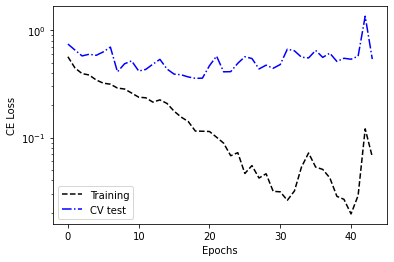

time: 546 ms (started: 2022-05-03 16:42:27 +00:00)


In [29]:
# Plotting the results:
# Remember that we defined our loss as MSE in the model.
plot_learning_curves(hist)

In [30]:
# Defining our function to see the evolution of error:
def plot_learning_curves_2(history):
  #We will omit the first 0 points for a better visualization:
  plt.plot(history['epoch'][0:],history['accuracy'][0:], "k--", linewidth=1.5, label="Training")
  plt.plot(history['epoch'][0:],history['val_accuracy'][0:], "b-.", linewidth=1.5, label="CV test")
  plt.legend()
# plt.ylim(1,100)
# plt.yscale("log")
  plt.xlabel("Epochs"),  plt.ylabel("Accuracy")

time: 5.85 ms (started: 2022-05-03 16:42:28 +00:00)


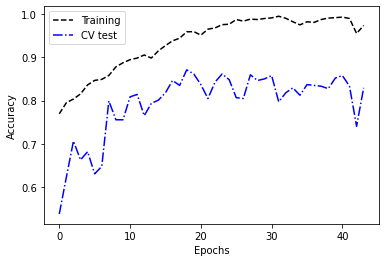

time: 206 ms (started: 2022-05-03 16:42:28 +00:00)


In [31]:
# Plotting the results:
# Remember that we defined our loss as MSE in the model.
plot_learning_curves_2(hist)

## Evaluation metrics

It is clearly seen that we are overfitting with the current model. Lets see our performance matrices. We will use confusion matrix, PR curve and ROC curve.

We will start with making predictions and then data conversion to be able to apply evaluation tools.

In [32]:
y_test_predictions = model_best.predict(X_test)


time: 2.65 s (started: 2022-05-03 16:42:28 +00:00)


In [33]:
#y_test_classes = model_best.predict_classes(X_test, verbose=0)
'''
tensorflow\python\keras\engine\sequential.py:455: UserWarning: model.predict_classes() is deprecated and will be removed after 2021-01-01. 
Please use instead:* np.argmax(model.predict(x), axis=-1), if your model does multi-class classification 
(e.g. if it uses a softmax last-layer activation).* (model.predict(x) > 0.5).astype("int32"), 
if your model does binary classification (e.g. if it uses a sigmoid last-layer activation).
'''
y_test_classes  = (y_test_predictions > 0.5).astype("int32")

time: 6.07 ms (started: 2022-05-03 16:42:31 +00:00)


In [35]:
# seeing an example output from sigmoid layer:
print(y_test_predictions[66], y_test_classes[66])

[0.00105342] [0]
time: 4.09 ms (started: 2022-05-03 16:42:31 +00:00)


`scikit-learn` metrics expect a 1D array of actual and predicted values for comparison so we must reduce the array dimensions.

In [36]:
y_test_predictions = y_test_predictions[:, 0]
y_test_classes = y_test_classes[:]

time: 804 µs (started: 2022-05-03 16:42:31 +00:00)


### Confusion matrix

In [37]:
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
# confusion_matrix(y_true, y_pred, *, labels=None, sample_weight=None, normalize=None)
conf_matrix = confusion_matrix(y_test,y_test_classes)
conf_matrix

array([[301,  59],
       [ 36, 264]])

time: 17 ms (started: 2022-05-03 16:42:31 +00:00)


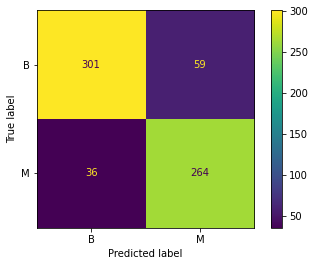

time: 264 ms (started: 2022-05-03 16:42:31 +00:00)


In [38]:
CM = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,display_labels=('B', 'M'))
CM.plot()

### Various scores

In [39]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test,y_test_classes)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test,y_test_classes)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test,y_test_classes)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test,y_test_classes)
print('F1 score: %f' % f1)
kappa_score = cohen_kappa_score(y_test,y_test_classes)
print('Cohens kappa: %f' % kappa_score)
# ROC AUC
auc_score = roc_auc_score(y_test, y_test_predictions)
print('ROC AUC: %f' % auc_score)

Accuracy: 0.856061
Precision: 0.817337
Recall: 0.880000
F1 score: 0.847512
Cohens kappa: 0.711565
ROC AUC: 0.931935
time: 29.5 ms (started: 2022-05-03 16:42:31 +00:00)


### PR Curve

Text(0.5, 1.0, 'Precision-Recall curve: Average Precision = 0.91')

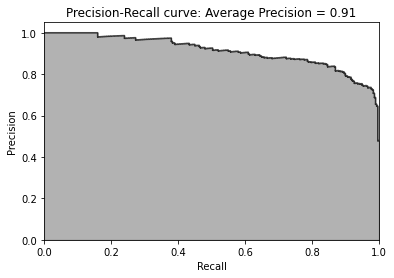

time: 226 ms (started: 2022-05-03 16:42:31 +00:00)


In [40]:
precision, recall, thresholds = precision_recall_curve(y_test,y_test_predictions)
average_precision = average_precision_score(y_test,y_test_predictions)

plt.step(recall, precision, color='k', alpha=0.7, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.3, color='k')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve: Average Precision = {0:0.2f}'.format(average_precision))

### ROC curve


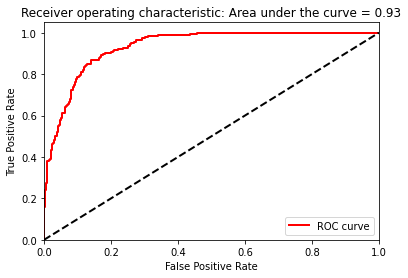

time: 183 ms (started: 2022-05-03 16:42:32 +00:00)


In [41]:
fpr, tpr, thresholds = roc_curve(y_test,y_test_predictions)
areaUnderROC = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic: Area under the curve = {0:0.2f}'.format(areaUnderROC))
plt.legend(loc="lower right")
plt.show()

# Looking for alternatives

Our score so far is compatable to an expert already but we would like to further improve our score. We will eplore two options here together and you will be given exercises to further play with the model. The options we will explore are:

+ pooling layers & 
+ data agumentation.

## Impact of Pooling

In the basic architecture, we introduce MaxPooling to downsample the input image, with the objective of reduce the computational load, the memory usage, and the number of parameters.By doing so, it also adds a bit of regularization into the picture.

Since we are overfitting, I will increase the pooling size and a bit of further regularization.

### Model architecture

In [31]:
def build_model_CNN_2():
  # input array shape for the network:
  input_shape = X_train.shape[1],X_train.shape[2],X_train.shape[3]
  #Here we will use Sequential API like we did in MLP
  model = models.Sequential([
  # Now we will introduce the layers. We will start with the convolution layer:
  #https://keras.io/api/layers/convolution_layers/
  #https://keras.io/api/layers/convolution_layers/convolution2d/
  Conv2D(64,(3,3),(1,1),padding='same',activation="relu",kernel_initializer="he_uniform",kernel_regularizer=regularizers.l1(0.001),input_shape=input_shape),
  #Adding the pooling layer:
  #https://keras.io/api/layers/pooling_layers/
  #https://keras.io/api/layers/pooling_layers/max_pooling2d/
  MaxPooling2D((3,3),padding='same'),
  BatchNormalization(),
  #Dropout(0.2),
  #
  #Second conv. layer:
  Conv2D(64,(3,3),(1,1),padding='same',activation="relu",kernel_initializer="he_uniform",kernel_regularizer=regularizers.l1(0.001)),
  MaxPooling2D((3,3),padding='same'),
  BatchNormalization(),
  #Dropout(0.2),
  #
  #Third conv. layer:
  Conv2D(64,(3,3),(1,1),padding='same',activation="relu",kernel_initializer="he_uniform",kernel_regularizer=regularizers.l1(0.001)),
  MaxPooling2D((3,3),padding='same'),
  BatchNormalization(),
  #Dropout(0.2),
  #
  #Connecting to dense layer:
  Flatten(),
  #Ready to link MLP
  Dense(128,activation="relu",kernel_initializer="he_uniform",kernel_regularizer=regularizers.l1(0.001)),
  BatchNormalization(),
  Dropout(0.2),
  Dense(1,activation="sigmoid")
  ])  
  model.compile(optimizer='Adam',loss = "binary_crossentropy", metrics=["accuracy"]) 
  return model
                             

time: 42.3 ms (started: 2022-05-03 17:29:08 +00:00)


In [43]:
#Looking at the graph:
build_model_CNN_2().summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 224, 224, 64)      1792      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 75, 75, 64)       0         
 2D)                                                             
                                                                 
 batch_normalization_8 (Batc  (None, 75, 75, 64)       256       
 hNormalization)                                                 
                                                                 
 conv2d_7 (Conv2D)           (None, 75, 75, 64)        36928     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 25, 25, 64)       0         
 2D)                                                             
                                                      

### Model training

Our model is ready as a graph object. Now we are ready to train it with our dataset. As usual, we will create a checkpoint to save better results and use early stopping to limit the training period, as well as over fitting.

In [44]:
#We will first create the object to feed fit() method:
myCheckpoint_2= keras.callbacks.ModelCheckpoint("my_best_model_2.h5", save_best_only=True)

time: 1.83 ms (started: 2022-05-03 16:42:32 +00:00)


In [45]:
#For its implementation:
#https://keras.io/api/callbacks/early_stopping/
# Here patience refers to the number of epochs with no improvement after which training will be stopped.
myEarly_stopping_2 = keras.callbacks.EarlyStopping(patience=25,restore_best_weights=True)

time: 2.06 ms (started: 2022-05-03 16:42:32 +00:00)


In [46]:
#Model Training
#--------------------------------------------------------------------------
#Hyperparameters
num_epochs = 100
batch_size = 32

time: 1.72 ms (started: 2022-05-03 16:42:32 +00:00)


In [47]:
# Model Training:
#-----------------------------------------------------------------------------
#Building the Keras models:
model_CNN_2 = build_model_CNN_2()

#Training step: Trains the model in silent mode (verbose = 0)
history_2= model_CNN_2.fit(X_train, y_train, epochs=num_epochs, batch_size=batch_size, validation_split=0.2, 
                                callbacks=[myCheckpoint_2,myEarly_stopping_2])#, verbose=0)
#Calling back the best model:
model_best_2= keras.models.load_model("my_best_model_2.h5")


Epoch 1/100
66/66 [==============================] - 13s 169ms/step - loss: 11.5069 - accuracy: 0.7729 - val_loss: 7.7155 - val_accuracy: 0.5625
Epoch 2/100
66/66 [==============================] - 9s 139ms/step - loss: 5.7955 - accuracy: 0.8113 - val_loss: 5.3855 - val_accuracy: 0.5398
Epoch 3/100
66/66 [==============================] - 9s 139ms/step - loss: 4.1126 - accuracy: 0.8231 - val_loss: 4.4270 - val_accuracy: 0.5417
Epoch 4/100
66/66 [==============================] - 9s 138ms/step - loss: 3.5318 - accuracy: 0.8198 - val_loss: 3.9781 - val_accuracy: 0.5682
Epoch 5/100
66/66 [==============================] - 9s 139ms/step - loss: 2.9108 - accuracy: 0.8388 - val_loss: 2.7672 - val_accuracy: 0.6269
Epoch 6/100
66/66 [==============================] - 9s 140ms/step - loss: 2.3554 - accuracy: 0.8317 - val_loss: 2.4353 - val_accuracy: 0.5530
Epoch 7/100
66/66 [==============================] - 9s 139ms/step - loss: 2.0213 - accuracy: 0.8227 - val_loss: 1.9036 - val_accuracy: 0.81

In [48]:
#Lets look into the history recorded:
hist_2 = pd.DataFrame(history_2.history)
hist_2.sample(3)

,loss,accuracy,val_loss,val_accuracy
46,0.710486,0.882409,0.720908,0.854167
0,11.506926,0.772878,7.715535,0.562500
27,1.009733,0.852537,0.990876,0.837121


time: 15.6 ms (started: 2022-05-03 16:55:56 +00:00)


In [49]:
#Adding epoch column:
hist_2['epoch'] = history_2.epoch
# As you can see, we have the losses as well as mae for both training and CV data:
hist_2.sample(3)

,loss,accuracy,val_loss,val_accuracy,epoch
3,3.531767,0.819820,3.978123,0.568182,3
55,0.650515,0.878615,0.829676,0.816288,55
20,1.110890,0.836415,1.211825,0.829545,20


time: 12.5 ms (started: 2022-05-03 16:55:56 +00:00)


In [50]:
# Defining our function to see the evolution of error:
def plot_learning_curves(history):
  #We will omit the first 0 points for a better visualization:
  plt.plot(history['epoch'][0:],history['loss'][0:], "k--", linewidth=1.5, label="Training")
  plt.plot(history['epoch'][0:],history['val_loss'][0:], "b-.", linewidth=1.5, label="CV test")
  plt.legend()
 # plt.ylim(1,100)
  plt.yscale("log")
  plt.xlabel("Epochs"),  plt.ylabel("CE Loss")

time: 4.7 ms (started: 2022-05-03 16:55:56 +00:00)


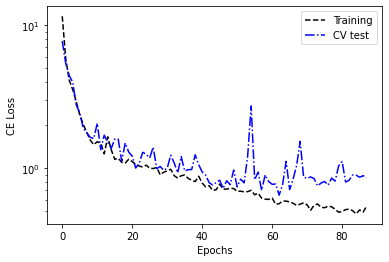

time: 384 ms (started: 2022-05-03 16:55:56 +00:00)


In [51]:
# Plotting the results:
# Remember that we defined our loss as MSE in the model.
plot_learning_curves(hist_2)

In [52]:
# Defining our function to see the evolution of error:
def plot_learning_curves_2(history):
  #We will omit the first 0 points for a better visualization:
  plt.plot(history['epoch'][0:],history['accuracy'][0:], "k--", linewidth=1.5, label="Training")
  plt.plot(history['epoch'][0:],history['val_accuracy'][0:], "b-.", linewidth=1.5, label="CV test")
  plt.legend()
# plt.ylim(1,100)
# plt.yscale("log")
  plt.xlabel("Epochs"),  plt.ylabel("Accuracy")

time: 5.19 ms (started: 2022-05-03 16:55:56 +00:00)


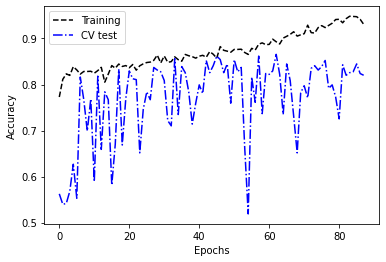

time: 206 ms (started: 2022-05-03 16:55:56 +00:00)


In [53]:
# Plotting the results:
# Remember that we defined our loss as MSE in the model.
plot_learning_curves_2(hist_2)

### Evaluation metrics

In [55]:
y_test_predictions_2 = model_best_2.predict(X_test)
#y_test_classes_2 = model_best_2.predict_classes(X_test, verbose=0)
y_test_classes_2  = (y_test_predictions_2 > 0.5).astype("int32")

time: 3.17 s (started: 2022-05-03 17:23:08 +00:00)


In [56]:
# seeing an example output from sigmoid layer:
print(y_test_predictions_2[0], y_test_classes_2[0])

[0.01371394] [0]
time: 2.6 ms (started: 2022-05-03 17:23:14 +00:00)


`scikit-learn` metrics expect a 1D array of actual and predicted values for comparison so we must reduce the array dimensions.

In [57]:
y_test_predictions_2 = y_test_predictions_2[:, 0]
y_test_classes_2 = y_test_classes_2[:, 0]

time: 1.69 ms (started: 2022-05-03 17:23:16 +00:00)


#### Confusion matrix

In [58]:
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
# confusion_matrix(y_true, y_pred, *, labels=None, sample_weight=None, normalize=None)
conf_matrix = confusion_matrix(y_test,y_test_classes_2)
conf_matrix

array([[288,  72],
       [ 27, 273]])

time: 7.84 ms (started: 2022-05-03 17:23:19 +00:00)


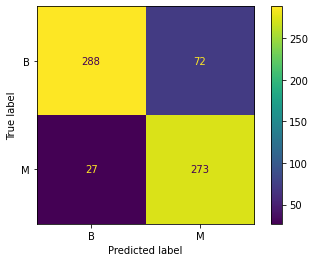

time: 251 ms (started: 2022-05-03 17:23:21 +00:00)


In [59]:
CM = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,display_labels=('B', 'M'))
CM.plot()

#### Various scores

In [60]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test,y_test_classes_2)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test,y_test_classes_2)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test,y_test_classes_2)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test,y_test_classes_2)
print('F1 score: %f' % f1)
kappa_score = cohen_kappa_score(y_test,y_test_classes_2)
print('Cohens kappa: %f' % kappa_score)
# ROC AUC
auc_score = roc_auc_score(y_test, y_test_predictions_2)
print('ROC AUC: %f' % auc_score)

Accuracy: 0.850000
Precision: 0.791304
Recall: 0.910000
F1 score: 0.846512
Cohens kappa: 0.701235
ROC AUC: 0.932944
time: 27.6 ms (started: 2022-05-03 17:23:24 +00:00)


#### PR Curve

Text(0.5, 1.0, 'Precision-Recall curve: Average Precision = 0.92')

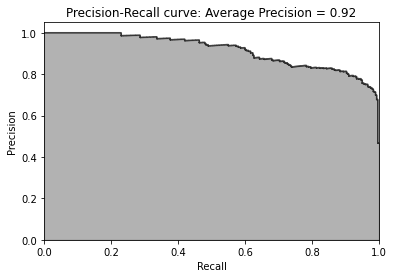

time: 212 ms (started: 2022-05-03 17:23:30 +00:00)


In [61]:
precision, recall, thresholds = precision_recall_curve(y_test,y_test_predictions_2)
average_precision = average_precision_score(y_test,y_test_predictions_2)

plt.step(recall, precision, color='k', alpha=0.7, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.3, color='k')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve: Average Precision = {0:0.2f}'.format(average_precision))

#### ROC curve


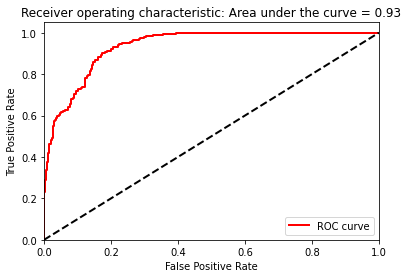

time: 203 ms (started: 2022-05-03 17:23:32 +00:00)


In [62]:
fpr, tpr, thresholds = roc_curve(y_test,y_test_predictions_2)
areaUnderROC = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic: Area under the curve = {0:0.2f}'.format(areaUnderROC))
plt.legend(loc="lower right")
plt.show()

# Increasing the volume of the data in image processing

It looks like we have hit the wall. We may push the predictive accuracy to a bit higher levels with fine tuning the model but there may be an alternative option as well. 

Image data augmentation is a useful method that can be used to artificially expand the size of a training dataset by creating slighlty modified versions of the original images in the dataset. Good news is we do not have to code it from the scratch; TF (Keras) already has a solution: `ImageDataGenerator` class:

https://keras.io/api/preprocessing/image/

```
tf.keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    zca_epsilon=1e-06,
    rotation_range=0,
    width_shift_range=0.0,
    height_shift_range=0.0,
    brightness_range=None,
    shear_range=0.0,
    zoom_range=0.0,
    channel_shift_range=0.0,
    fill_mode="nearest",
    cval=0.0,
    horizontal_flip=False,
    vertical_flip=False,
    rescale=None,
    preprocessing_function=None,
    data_format=None,
    validation_split=0.0,
    dtype=None,
)

```

The options include, but not limited to

* `width_shift_range` and `height_shift_range`:  shifts the image,
* `horizontal_flip` and `vertical_flip` :  flips images
* `rotation_range` : rotates image
* `brightness_range` : setting brightness 
* `zoom_range` : image zooming

see also:

https://www.tensorflow.org/tutorials/images/data_augmentation

https://towardsdatascience.com/exploring-image-data-augmentation-with-keras-and-tensorflow-a8162d89b844

https://www.pyimagesearch.com/2019/07/08/keras-imagedatagenerator-and-data-augmentation/





## Implementation

In [25]:
datagen = ImageDataGenerator(
        featurewise_center=False,  
        samplewise_center=False,  
        featurewise_std_normalization=False, 
        samplewise_std_normalization=False,  
        zca_whitening=False, 
        rotation_range=20, 
        zoom_range = 0.1, 
        width_shift_range=0.2,  
        height_shift_range=0.2,
        horizontal_flip=True,  
        vertical_flip=True, 
        preprocessing_function=None,
        validation_split=0.2)

datagen.fit(X_train)

time: 1.72 s (started: 2022-05-03 17:26:41 +00:00)


In [26]:
#We will first create the object to feed fit() method:
myCheckpoint_3= keras.callbacks.ModelCheckpoint("my_best_model_3.h5", save_best_only=True)

time: 1.11 ms (started: 2022-05-03 17:26:42 +00:00)


In [2]:
#For its implementation:
#https://keras.io/api/callbacks/early_stopping/
# Here patience refers to the number of epochs with no improvement after which training will be stopped.
#myEarly_stopping_3 = keras.callbacks.EarlyStopping(patience=25,restore_best_weights=True)

In [27]:
# Alternative checkpoint - if accuracy doesn't improve after 3 epoch then reduce lr by factor 0.5 
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.618,patience=3, min_lr=0.00001)

time: 1.37 ms (started: 2022-05-03 17:26:42 +00:00)


In [32]:
model_CNN = build_model_CNN_2()

time: 449 ms (started: 2022-05-03 17:29:50 +00:00)


In [34]:
#Model Training
#--------------------------------------------------------------------------
#Hyperparameters
num_epochs = 100
batch_size = 32

time: 2.36 ms (started: 2022-05-03 17:30:25 +00:00)


In [35]:
# Training the model:
# here we will fit the model on batches with real-time data augmentation;
history_3 = model_CNN.fit(datagen.flow(X_train, y_train, batch_size=batch_size,subset='training'),
                          epochs=num_epochs, 
                          #validation_split=0.2,
                          validation_data=datagen.flow(X_train, y_train, batch_size=batch_size, subset='validation'), 
                          callbacks=[myCheckpoint_3,reduce_lr])#, verbose=0))

#Calling back the best model:
model_best_3= keras.models.load_model("my_best_model_3.h5")

Epoch 1/100
66/66 [==============================] - 46s 526ms/step - loss: 10.9030 - accuracy: 0.7678 - val_loss: 7.1882 - val_accuracy: 0.5825 - lr: 0.0010
Epoch 2/100
66/66 [==============================] - 34s 519ms/step - loss: 5.3557 - accuracy: 0.8081 - val_loss: 4.6558 - val_accuracy: 0.5655 - lr: 0.0010
Epoch 3/100
66/66 [==============================] - 32s 490ms/step - loss: 3.6738 - accuracy: 0.7986 - val_loss: 3.4422 - val_accuracy: 0.5636 - lr: 0.0010
Epoch 4/100
66/66 [==============================] - 32s 493ms/step - loss: 2.7995 - accuracy: 0.8081 - val_loss: 2.9928 - val_accuracy: 0.5636 - lr: 0.0010
Epoch 5/100
66/66 [==============================] - 33s 503ms/step - loss: 2.2855 - accuracy: 0.8152 - val_loss: 2.4469 - val_accuracy: 0.5712 - lr: 6.1800e-04
Epoch 6/100
66/66 [==============================] - 32s 492ms/step - loss: 1.9640 - accuracy: 0.8137 - val_loss: 1.9748 - val_accuracy: 0.6736 - lr: 6.1800e-04
Epoch 7/100
66/66 [==============================

In [36]:
#Lets look into the history recorded:
hist_3 = pd.DataFrame(history_3.history)
hist_3.head(3)

,loss,accuracy,val_loss,val_accuracy,lr
0,10.902965,0.767772,7.188190,0.582543,0.001
1,5.355653,0.808057,4.655771,0.565465,0.001
2,3.673750,0.798578,3.442165,0.563567,0.001


time: 57.3 ms (started: 2022-05-03 18:24:54 +00:00)


In [37]:
#Lets look into the history recorded:
hist_3 = pd.DataFrame(history_3.history)
hist_3.sample(3)

,loss,accuracy,val_loss,val_accuracy,lr
15,0.953084,0.834123,1.140936,0.772296,0.000382
60,0.581325,0.881990,0.591832,0.870968,0.000010
16,0.981776,0.827962,1.071844,0.787476,0.000382


time: 25.8 ms (started: 2022-05-03 18:24:54 +00:00)


In [38]:
#Adding epoch column:
hist_3['epoch'] = history_3.epoch
# As you can see, we have the losses as well as mae for both training and CV data:
hist_3.sample(3)

,loss,accuracy,val_loss,val_accuracy,lr,epoch
99,0.570346,0.885308,0.591955,0.861480,0.00001,99
72,0.596429,0.869668,0.594464,0.886148,0.00001,72
80,0.587380,0.875829,0.605871,0.853890,0.00001,80


time: 22.1 ms (started: 2022-05-03 18:24:54 +00:00)


In [39]:
# Defining our function to see the evolution of error:
def plot_learning_curves(history):
  #We will omit the first 0 points for a better visualization:
  plt.plot(history['epoch'][0:],history['loss'][0:], "k--", linewidth=1.5, label="Training")
  plt.plot(history['epoch'][0:],history['val_loss'][0:], "b-.", linewidth=1.5, label="CV test")
  plt.legend()
 # plt.ylim(1,100)
  plt.yscale("log")
  plt.xlabel("Epochs"),  plt.ylabel("CE Loss")

time: 8.95 ms (started: 2022-05-03 18:24:54 +00:00)


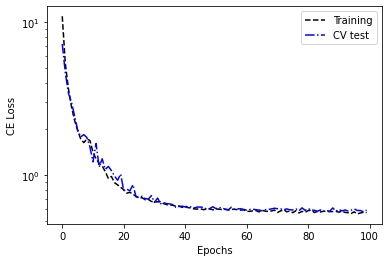

time: 598 ms (started: 2022-05-03 18:24:54 +00:00)


In [40]:
# Plotting the results:
# Remember that we defined our loss as MSE in the model.
plot_learning_curves(hist_3)

In [41]:
# Defining our function to see the evolution of error:
def plot_learning_curves_2(history):
  #We will omit the first 0 points for a better visualization:
  plt.plot(history['epoch'][0:],history['accuracy'][0:], "k--", linewidth=1.5, label="Training")
  plt.plot(history['epoch'][0:],history['val_accuracy'][0:], "b-.", linewidth=1.5, label="CV test")
  plt.legend()
  plt.ylim(0.5,1)
# plt.yscale("log")
  plt.xlabel("Epochs"),  plt.ylabel("Accuracy")

time: 5.14 ms (started: 2022-05-03 18:24:55 +00:00)


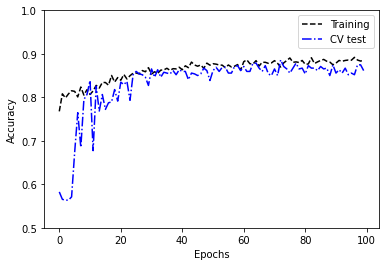

time: 215 ms (started: 2022-05-03 18:24:55 +00:00)


In [42]:
# Plotting the results:
# Remember that we defined our loss as MSE in the model.
plot_learning_curves_2(hist_3)

### Evaluation metrics

In [43]:
y_test_predictions_3 = model_best_3.predict(X_test)
#y_test_classes_3 = model_best_3.predict_classes(X_test, verbose=0)
y_test_classes_3  = (y_test_predictions_3 > 0.5).astype("int32")


time: 2.19 s (started: 2022-05-03 18:24:55 +00:00)


In [44]:
# seeing an example output from sigmoid layer:
print(y_test_predictions_3[0], y_test_classes_3[0])

[0.00460856] [0]
time: 2.98 ms (started: 2022-05-03 18:24:57 +00:00)


`scikit-learn` metrics expect a 1D array of actual and predicted values for comparison so we must reduce the array dimensions.

In [45]:
y_test_predictions_3 = y_test_predictions_3[:, 0]
y_test_classes_3 = y_test_classes_3[:, 0]

time: 1.4 ms (started: 2022-05-03 18:24:57 +00:00)


#### Confusion matrix

In [46]:
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
# confusion_matrix(y_true, y_pred, *, labels=None, sample_weight=None, normalize=None)
conf_matrix = confusion_matrix(y_test,y_test_classes_3)
conf_matrix

array([[319,  41],
       [ 52, 248]])

time: 15.3 ms (started: 2022-05-03 18:24:57 +00:00)


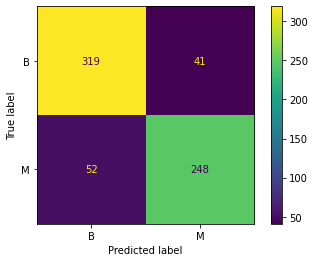

time: 248 ms (started: 2022-05-03 18:24:57 +00:00)


In [47]:
CM = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,display_labels=('B', 'M'))
CM.plot()

#### Various scores

In [48]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test,y_test_classes_3)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test,y_test_classes_3)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test,y_test_classes_3)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test,y_test_classes_3)
print('F1 score: %f' % f1)
kappa_score = cohen_kappa_score(y_test,y_test_classes_3)
print('Cohens kappa: %f' % kappa_score)
# ROC AUC
auc_score = roc_auc_score(y_test, y_test_predictions_3)
print('ROC AUC: %f' % auc_score)

Accuracy: 0.859091
Precision: 0.858131
Recall: 0.826667
F1 score: 0.842105
Cohens kappa: 0.714962
ROC AUC: 0.949769
time: 26.9 ms (started: 2022-05-03 18:24:57 +00:00)


#### PR Curve

Text(0.5, 1.0, 'Precision-Recall curve: Average Precision = 0.94')

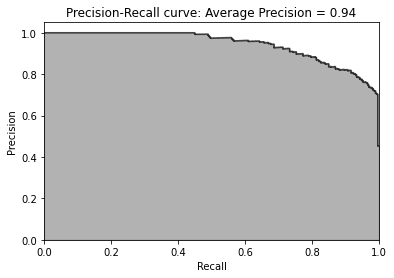

time: 219 ms (started: 2022-05-03 18:24:57 +00:00)


In [49]:
precision, recall, thresholds = precision_recall_curve(y_test,y_test_predictions_3)
average_precision = average_precision_score(y_test,y_test_predictions_3)

plt.step(recall, precision, color='k', alpha=0.7, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.3, color='k')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve: Average Precision = {0:0.2f}'.format(average_precision))

#### ROC curve


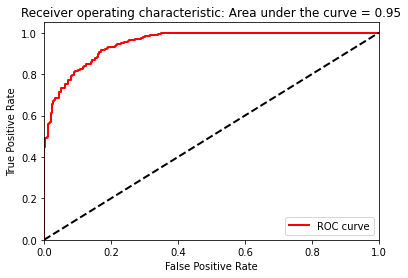

time: 182 ms (started: 2022-05-03 18:24:58 +00:00)


In [50]:
fpr, tpr, thresholds = roc_curve(y_test,y_test_predictions_3)
areaUnderROC = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic: Area under the curve = {0:0.2f}'.format(areaUnderROC))
plt.legend(loc="lower right")
plt.show()

# Exercise options

+ Play with learning rate and regularization options.

+ play with the architecture.

+ try different number of filters.

+ explore the impact of pooling and maxpooling. 

# Reading materials and further references


## Basic tutorials and resources on CNN

+ [Basic CNN implementation](https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-cifar-10-photo-classification/)




## Previous challenges and calls for the task:

+ [ISIC 2018: Skin Lesion Analysis Towards Melanoma Detection](https://challenge2018.isic-archive.com/)

+  [HAM10000 dataset](https://www.kaggle.com/kmader/skin-cancer-mnist-ham10000)

+ [SIIM-ISIC Melanoma Classification](https://www.kaggle.com/c/siim-isic-melanoma-classification/data)







## Case study: Skin cancer classification

+ [What is melanoma?](https://www.youtube.com/watch?v=mkYBxfKDyv0)

+ [Skin cancer classification with deep learning](https://cs.stanford.edu/people/esteva/nature/)

+ [Skin Cancer Classification Using Convolutional Neural Networks: Systematic Review](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6231861/)

+ [DePicT Melanoma Deep-CLASS](https://bmcbioinformatics.biomedcentral.com/articles/10.1186/s12859-020-3351-y)
